In [3]:
import os
import h5py
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from IPython.display import HTML
from matplotlib.colors import TwoSlopeNorm, NoNorm

from astropy import units as u

from visualize_foreground import *

# Format colorbar ticks in scientific notation
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)

R_sun = 6.957e10

In [2]:
def read_fg_3D(file_path):
    # NOW THIS IS A LITTLE BIT HACKY TO MAKE NEW DATA WORK WITH OLD CODE
    with h5py.File(file_path, 'r') as f:
        T1 = np.array(f['variables/T1'])
        rho1 = np.array(f['variables/rho1'])
        p1 = np.array(f['variables/p1'])
        s1 = np.array(f['variables/s1'])
        vx = np.array(f['variables/vx'])
        vy = np.array(f['variables/vy'])
        vz = np.array(f['variables/vz'])
        
        t = np.array(f['grid_info/t'])

        nx = np.array(f['grid_info/nx'])
        ny = np.array(f['grid_info/ny'])
        nz = np.array(f['grid_info/nz'])
        nz_full = np.array(f['grid_info/nz_full'])
        nz_ghost = np.array(f['grid_info/nz_ghost'])
        dx = np.array(f['grid_info/dx'])
        dy = np.array(f['grid_info/dy'])
        dz = np.array(f['grid_info/dz'])
        z0 = np.array(f['grid_info/z0'])
        z1 = np.array(f['grid_info/z1'])
        x0 = np.array(f['grid_info/x0'])
        x1 = np.array(f['grid_info/x1'])
        y0 = np.array(f['grid_info/y0'])
        y1 = np.array(f['grid_info/y1'])
        
        variables = {"T1": T1, "rho1": rho1, "p1": p1, "s1": s1, "vx": vx, "vy":vy, "vz": vz}
        info = {"t": t, "nx": nx, "ny":ny, "nz": nz, "nz_full": nz_full, "nz_ghost": nz_ghost, "dx": dx, "dy":dy, "dz": dz, "z0": z0, "z1": z1, "x0": x0, "x1": x1, "y0":y0, "y1":y1}
    return variables, info

In [14]:
variables["T1"].shape

(24, 20, 20)

In [45]:
file_path = "../data/3d_save/"

variables_bg, _ = read_bg(file_path+"background.h5")


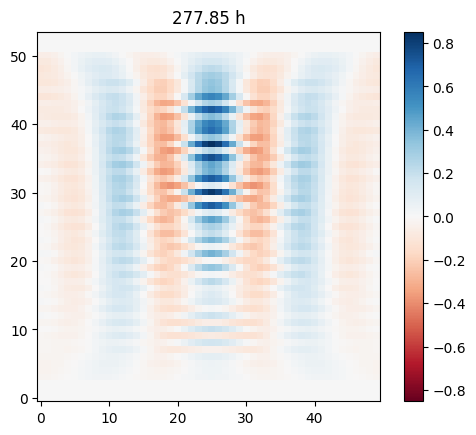

In [88]:
def plot_mean_3D(ax, full_filepath, var='vz', axis='z'):
    # Read variables and info
    variables, _ = read_fg_3D(full_filepath)
    
    variable = variables[var]

    if axis == 'z':
        data = np.mean(variable, axis=0)
    elif axis == 'y':
        data = np.mean(variable, axis=1)
    elif axis == 'x':
        data = np.mean(variable, axis=2)

    vmax = np.max(data)
    vmin = -vmax
    im = ax.imshow(data, cmap="RdBu", origin="lower", vmin=vmin, vmax=vmax)
    return im

def animate_mean_3D(file_path, var='vz', axis='z'):
    # Identify number of snapshot files based on your naming convention
    snap_id = 0
    snaps = []
    while True:
        snap_filepath = file_path + f"snap{snap_id}.h5"
        if os.path.exists(snap_filepath):
            snaps.append(snap_filepath)
            snap_id += 1
        else:
            break
     
    fig, ax = plt.subplots()
    im = plot_mean_3D(ax, snaps[0], var, axis)
    plt.colorbar(im, ax=ax)

    def update(frame):
        ax.clear()
        snap_filepath = snaps[frame]
        im = plot_mean_3D(ax, snap_filepath, var, axis)
        plt.title(f"Snap {frame}")
        return im,

    # Assuming each snapshot file is treated as one frame in the animation
    ani = FuncAnimation(fig, update, frames=len(snaps), blit=True, repeat=False)

    return ani
    

def plot_coss_section_3D(im, filepath, snap, var="vz", axis="z", index=0, vmin=None, vmax=None):
    variables, info = read_fg_3D(filepath+"snap"+f"{snap}.h5")

    variable = variables[var]
    nz_full = info['nz_full']
    ny = info["ny"]
    nx = info['nx']

    if axis == 'z':
        data = variable[index, :, :]
    elif axis == 'y':
        data = variable[:,index, :]
    elif axis == 'x':
        data = variable[:, :,index]

    if vmax==None:
        vmax = np.max(variable)
        vmin = -vmax

    im.set_array(data)
    im.set_clim(vmin, vmax)

    return info['t']*u.s

def animate_cross_section_3D(filepath, var="vz", axis="z", index=0, vmin=None, vmax=None):
    fig, ax = plt.subplots()

    def update(frame):
        t = plot_coss_section_3D(im, filepath, frame, var, axis, index, vmin, vmax)
        plt.title(f"{t.to('h'):.2f}")
        return im,

    snaps = []
    snap_id = 0
    while True:
        snap_filepath = file_path + f"snap{snap_id}.h5"
        if os.path.exists(snap_filepath):
            snaps.append(snap_filepath)
            snap_id += 1
        else:
            break

    variables, info = read_fg_3D(filepath+"snap0.h5")
    variable = variables[var]
    if axis == 'z':
        data = variable[index, :, :]
    elif axis == 'y':
        data = variable[:,index, :]
    elif axis == 'x':
        data = variable[:, :,index]
    if vmax==None:
        vmax_ = np.max(variable)
        vmin_ = -vmax_
    else:
        vmax_ = vmax
        vmin_ = vmin

    im = ax.imshow(data, cmap="RdBu", origin="lower", vmin=vmin_, vmax=vmax_, animated=True)
    plt.colorbar(im, ax=ax)

    ani = FuncAnimation(fig, update, frames=len(snaps), blit=True)
    return ani


def animate_cross_section_3D_one_snap(full_filepath, var='vz', axis='z'):
    # Read variables and info
    variables, info = read_fg_3D(full_filepath)
    
    variable = variables[var]
    nz_full = info['nz_full']
    ny = info["ny"]
    nx = info['nx']

    vmax = np.max(variable)
    vmin = -vmax

    fig, ax = plt.subplots()

    def update(frame):
        if axis == 'z':
            data = variable[frame, :, :]
        elif axis == 'y':
            data = variable[:,frame, :]
        elif axis == 'x':
            data = variable[:, :,frame]
            
        im.set_array(data)
        im.set_clim(vmin, vmax)
        plt.title(f"{frame}")
        return im,

    if axis == 'z':
        data = variable[0, :, :]
        #vmax = np.max(variable, axis=0)
    elif axis == 'y':
        data = variable[:, 0, :]
        #vmax = np.max(variable, axis=1)
    elif axis == 'x':
        data = variable[:, :, 0]
        #vmax = np.max(variable, axis=2)
    
    im = ax.imshow(data, cmap="RdBu", origin="lower", vmin=vmin, vmax=vmax, animated=True)
    plt.colorbar(im, ax=ax)

    ani = FuncAnimation(fig, update, frames=nz_full-1, blit=True)
    return ani

#ani = animate_cross_section_3D_one_snap(file_path+"snap40.h5", "s1", "z")
#ani = animate_mean_3D(file_path, "vz", "x")
vmin = None
vmax = None

anim = animate_cross_section_3D(file_path, "vz", "y", 25, vmin, vmax)
anim.save("3D_vz_y.mp4", writer='ffmpeg', fps=5, extra_args=['-vcodec', 'libx264'])
#HTML(ani.to_jshtml())


# Usage example:
# ani_mean = animate_mean_3D("path_to_your_file/snap50.h5", var='vz', axis='z')
# ani_cross_section = animate_cross_section_3D("path_to_your_file/snap50.h5", var='vz', axis='z', index=5)
# plt.show()

"""
1 SNAP PR. 3 TIME ER FOR LITE FOR Å SKJØNNE HVA SOM FOREGÅR. PRØV MED 1 PR TIME
"""

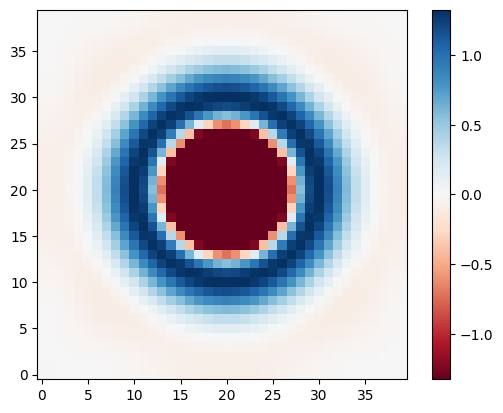

In [54]:
variables, info = read_fg_3D(file_path+"snap50.h5")

nz_full = info['nz_full']
ny = info["ny"]
nx = info['nx']

ax_mean = 0

var = 'vz'
variable = variables[var]
mean_var = np.mean(variable, axis=ax_mean)
vmax = np.max(mean_var)
vmin = -vmax
#plt.imshow(variables["p1"][int(nz_full/2),:,:], cmap="RdBu", origin="lower")
#plt.imshow(variables["p1"][:,int(ny/2),:], cmap="RdBu", origin="lower")

plt.imshow(mean_var, cmap="RdBu", origin="lower", vmin=vmin, vmax=vmax)

plt.colorbar()